In [1]:
from main_hpo import HPO_SIM
from grasp_core import GRASP_HPO

from sklearn.datasets import load_breast_cancer, load_digits

from queue import PriorityQueue
import pandas as pd
import matplotlib as plt

In [2]:
sim = HPO_SIM()
sim.prepare_dataset(load_breast_cancer())

In [3]:
hp_ranges = {
    'n_estimators': (50, 500),
    'max_depth': (3, 10),
    'colsample_bytree': (0.5, 1),
    'reg_lambda': (0.01, 1.0),
    'subsample': (0.5, 1.0)
}

ghpo = GRASP_HPO(sim.evaluate_solution)
ghpo.configure_ranges(hp_ranges)

In [4]:
pq = ghpo.get_intermediate()
after_phase_1 = []
for combo in pq.queue: after_phase_1.append(combo[0])
inputs = pd.DataFrame({'score': after_phase_1})
inputs
# list of different HP configuration k-fold scores in priority queue FROM BUILD PHASE

,score
0,0.964509
1,0.964509


In [5]:
# achieved best score from build phase
to_improve = max(after_phase_1)
to_improve

0.9645092460881936

In [6]:
many_tests = []

for i in range(15):
    after_ls = {}

    combo1 = PriorityQueue()
    combo2 = PriorityQueue()
    combo3 = PriorityQueue()
    combo4 = PriorityQueue()
    for c in pq.queue: 
        combo1.put(c)
        combo2.put(c)
        combo3.put(c)
        combo4.put(c)

    
    ghpo.set_margin(.1)
    # test each function and save k-fold mean score
    score, solution = ghpo.tune_intermediate(combo1)
    after_ls['margin +/- 5%'] = [score]

    ghpo.set_margin(.3)
    score, solution = ghpo.tune_intermediate(combo2)
    after_ls['margin +/- 15%'] = [score]

    ghpo.set_margin(.5)
    score, solution = ghpo.tune_intermediate(combo3)
    after_ls['margin +/- 25%'] = [score]

    ghpo.set_margin(.8)
    score, solution = ghpo.tune_intermediate(combo4)
    after_ls['margin +/- 40%'] = [score]

    outputs = pd.DataFrame(after_ls, index=['score'])
    outputs = pd.melt(outputs)

    dif = [score - to_improve for score in outputs.loc[:,'value']]
    outputs['increase'] = dif

    percentage = [inc / to_improve for inc in outputs.loc[:,'increase']]
    outputs['percentage'] = percentage

    many_tests.append(outputs)
    print('Trial {} completed'.format(i))

Trial 0 completed
Trial 1 completed
Trial 2 completed
Trial 3 completed
Trial 4 completed
Trial 5 completed
Trial 6 completed
Trial 7 completed
Trial 8 completed
Trial 9 completed
Trial 10 completed
Trial 11 completed
Trial 12 completed
Trial 13 completed
Trial 14 completed


In [7]:
result = pd.concat(many_tests)
avgs = result.groupby('variable', as_index=False).mean()
avgs = avgs.sort_values(by=['percentage'], ascending=False)
avgs

,variable,value,increase,percentage
2,margin +/- 40%,0.973465,0.008956,0.009286
3,margin +/- 5%,0.973465,0.008956,0.009286
1,margin +/- 25%,0.972868,0.008359,0.008667
0,margin +/- 15%,0.971674,0.007165,0.007429


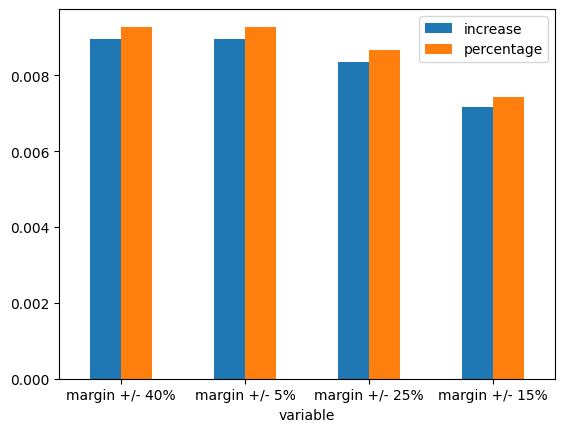

In [8]:
ax = avgs.plot.bar(x='variable', y=['increase', 'percentage'], rot=0)
#fig = ax.get_figure()
#fig.savefig('figs/test5-40trials-956b-25ls')

,variable,value,increase,percentage
0,margin +/- 15%,0.964509,0.000000,0.000000
1,margin +/- 25%,0.964509,0.000000,0.000000
2,margin +/- 40%,0.973465,0.008956,0.009286
3,margin +/- 5%,0.973465,0.008956,0.009286


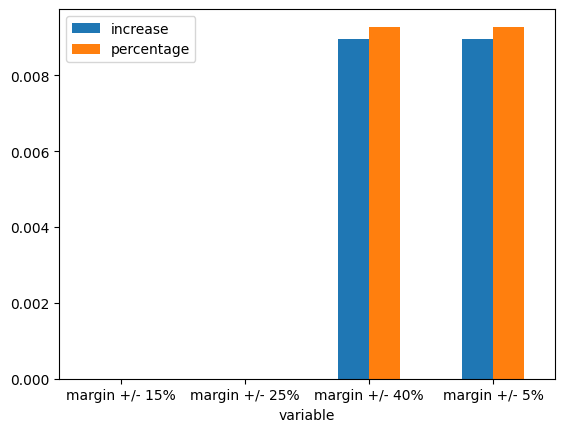

In [13]:
min = result.groupby('variable', as_index=False).min()
ax1 = min.plot.bar(x='variable', y=['increase', 'percentage'], rot=0)
#fig1 = ax1.get_figure()
#fig1.savefig('figs/test3-30trials-958b-50ls-MIN')
min